
# Part 2: Preprocessing Natural Language Based Features

**_TABLE OF CONTENT_**

-  [ ] Twitter data is removed from this work since not enough historic data could be retrieved
- [X] Financial news has been collected and additional collection of data is added


            1. Data Exploration
            2. Data Quality and Missing Values
            3. Feature Calculations

Import all necessary libraries and set notebook settings

In [1]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# Specific
from nltk.internals import Counter
from preprocessing import *
from helpFunctions import *

# Notebook and graph visualisation
from IPython.core.display import display
plt.style.reload_library()
plt.style.use(['science','no-latex', 'high-contrast'])
sns.set_context("paper")
sns.set_style("whitegrid")


# Important variables
tickers = get_tickers()

Postgres connection is closed


## 1. Data Exploration
We take a quick look at how the data is stored in our database

In [2]:
%%time
#Create select query to get all articles out the database
query = 'select * from news'
#Pre specify the column names
column_names = ['title', 'text', 'date']
# Retrieve the data from the database in a dataframe with the specified column names
yf_news_df = postgresql_to_dataframe(query, column_names)
# Show the first observations of the dataset
display(yf_news_df.head())
yf_news_df.info()


,title,text,date
0,"[""China warns Taiwan independence 'means war' ...",[],2021-01-29
1,"[""Breonna Taylor jurors: Louisville police 'di...",[],2020-10-28
2,['Mogul behind pardon push pledged donation to...,[],2020-12-11
3,"['US puts hold on foreign arms sales, includin...",[],2021-01-28
4,['Mortgage rate dip the reason for new-home sa...,"['Brad Dillman, Cortland Chief Economist, join...",2021-01-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202678 entries, 0 to 202677
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   202678 non-null  object
 1   text    202678 non-null  object
 2   date    202678 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB
Wall time: 2.37 s


We can see we have around 202.000 articles in our data set
This is mainly due to the rich data set that has been added to the own collection of data

Next we inspect the number of articles we have per day

In [3]:
#Sort articles according to date
yf_news_df.sort_values(by = 'date', inplace= True)
#Count the number of articles for each day
count = yf_news_df.groupby(by= 'date', as_index= False).\
                    count()[['date', 'title']].\
                    rename(columns = {'title': 'count'})
display(count.head(10))

,date,count
0,2020-03-21,20
1,2020-03-22,247
2,2020-03-23,999
3,2020-03-24,1017
4,2020-03-25,990
5,2020-03-26,1019
6,2020-03-27,985
7,2020-03-28,315
8,2020-03-29,355
9,2020-03-30,690


We see a highly diverse number of articles collected.
Our own collecting method has only retrieved 65 articles on average per day,
therefore we decide to downsample the external dataset.
This will also ensure computation time stays manageable.

Additionally, we only keep days that are trading days.
Since in a latter step text cleaning, sentiment analysis and more
will be performed unnecessary days are removed before hand

In [4]:
# Create empty dataframe
news = pd.DataFrame(columns=['date', 'title', 'text'])
#Retrieve trading days from 22/03/20 until now
trading_days = get_trading_days(date(2020,3,22))
 # Show the total number of trading days passed
print(len(trading_days))
# Go through all trading days to downsample if there are more than a hundred articles
for val in trading_days:
    try:
        #Check number of articles of that day more than a hundred
        if(int(count.loc[count['date'] == val, 'count']) > 100):
            #Randomly take 100 articles from that day and add to new dataframe
            news = news.append(yf_news_df[yf_news_df['date'] == val].sample(100))
        else:
            #Less than a 100 articles -> add all articles of that day to new df
            news = news.append(yf_news_df[yf_news_df['date'] == val])
    except (Exception):
        print('No news data for: ', val) # If we have no articles on one of the days, show us which day

277
No news data for:  2020-11-30
No news data for:  2021-02-26
No news data for:  2021-03-05
No news data for:  2021-03-26
No news data for:  2021-04-02
No news data for:  2021-04-05
No news data for:  2021-04-06
No news data for:  2021-04-07
No news data for:  2021-04-08
No news data for:  2021-04-09
No news data for:  2021-04-12
No news data for:  2021-04-13
No news data for:  2021-04-14
No news data for:  2021-04-15


We notice that we have 4 days were no news articles were collected.
One of those days indicated is today, since this code is run before collecting todays articles.
We have 3 missing days over a total of more than 250 trading days, which we consider not bad.
We will leave these days out of the data set

In [5]:
print(news.shape)

(22520, 3)


We inspect the shape of our newly created news dataframe.
We still have around 22.000 articles in our dataset after removing unnecessary days and downsampling the dataset


In [6]:
%%time
#Get articles with all cleaning and feature calculations done
yf_news_df = get_yf_news()
print(yf_news_df.shape)
yf_news_df.head()

(22468, 25)
Wall time: 46.1 s


,date,title,text,title_cleaned_tokenized,text_cleaned_tokenized,title_cleaned,polarity,subjectivity,Business,News,...,YF,CNBC,AAPL,AMZN,FB,GOOG,NFLX,hold,buy,sell
741,2020-03-23,(Bloomberg)- Internet traffic is surging but t...,"(Planes are grounded, factories shuttered and ...","[bloomberg, internet, traffic, surging, pipe, ...","[plane, grounded, factory, shuttered, city, lo...",bloomberg internet traffic surging pipe ’ burs...,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1087,2020-03-23,(Bloomberg)- World's Biggest Lockdown Triggers...,,"[bloomberg, world, biggest, lockdown, trigger,...",[],bloomberg world biggest lockdown trigger recor...,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
879,2020-03-23,(Bloomberg)- Brussels Edition: Time to Throw A...,,"[bloomberg, brussels, edition, time, throw, aw...",[],bloomberg brussels edition time throw away rul...,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,2020-03-23,(Bloomberg)- Italy Virus Deaths Fall for Secon...,(Italy Virus Deaths Fall for Second Day as Ger...,"[bloomberg, italy, virus, death, fall, second,...","[italy, virus, death, fall, second, day, germa...",bloomberg italy virus death fall second day ge...,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
915,2020-03-23,(Reuters)- Factbox: Stock exchanges revise tra...,(Global stock exchanges are changing trading r...,"[reuters, factbox, stock, exchange, revise, tr...","[global, stock, exchange, changing, trading, r...",reuters factbox stock exchange revise trading ...,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Check for duplicates
Since it is possible that some articles are still on the first page the next day, duplicates are possible
We check for duplicates here

In [7]:
#Check if there are still duplicates left after cleaning
print('Total number of duplicates: ', yf_news_df['title'].duplicated().sum())

Total number of duplicates:  0


#### Check for missing values


In [8]:
# Set empty string = NAN to detect where missing article title and text content is
yf_news_df['text'] = np.where(yf_news_df['text'] == '', np.NaN, yf_news_df['text'])
yf_news_df['title'] = np.where(yf_news_df['title'] == '', np.NaN, yf_news_df['title'])
# Use Help function to show missing values
get_NAN_columns(yf_news_df)

,Absolute value,Percentage
text,5606.0,0.25


For a quarter of the articles we only have the title of the article and not the content
In the scraping process for one web adress we were able to retrieve the content
but for another we were not.
The externel dataframe has most of its content but also some missing

#### Distribution of articles collected

In [9]:
print('Number of days collected: ', len(yf_news_df.date.unique()))
trading_days = get_trading_days()
print('Number of trading days until now', len(trading_days))
print('Total number of titles collected: ', len(yf_news_df))
print('Total number of article content collected: ', len(yf_news_df.text.unique()))
print('Average number of articles collected per day: ', len(yf_news_df)/len(yf_news_df.date.unique()))

Number of days collected:  263
Number of trading days until now 277
Total number of titles collected:  22468
Total number of article content collected:  16371
Average number of articles collected per day:  85.4296577946768


We notice we have on average 86 articles for each day (after downsampling)

In [10]:
yf_news_df['date'] = pd.to_datetime(yf_news_df.date) #Change type to datetime
collected_dates = yf_news_df.date.dt.date.unique() #Create list of all dates that we have data from
diff = list(set(trading_days) - set(collected_dates)) #Create list of days that should be collected but are not

# Show findings
print('Total trading days : ', len(trading_days))
print('Total collected days: ', len(collected_dates))
print('Difference between them: ', len(diff))

# Show all dates that should be included
diff.sort()
for dt in diff:
    print(dt)

Total trading days :  277
Total collected days:  263
Difference between them:  14
2020-11-30
2021-02-26
2021-03-05
2021-03-26
2021-04-02
2021-04-05
2021-04-06
2021-04-07
2021-04-08
2021-04-09
2021-04-12
2021-04-13
2021-04-14
2021-04-15


Inspect the distribution of articles

,title
count,263.000000
mean,85.429658
std,21.277380
min,20.000000
25%,62.000000
50%,100.000000
75%,100.000000
max,100.000000


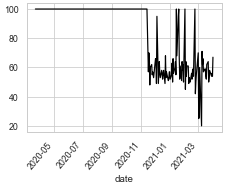

In [11]:
daily_articels = pd.DataFrame(yf_news_df.groupby('date').count()['title'])
daily_articels.plot(rot = 50, color = 'k', legend = False)
display(daily_articels.describe())

We notice we have very consistent number of articles until november but after the average ad consisitency drops
The number of articles available on the web adresses of Yahoo Finance fluctuates
For one trading day we only have 20 articles collected

<AxesSubplot:title={'center':'Distribution of the number of daily articles'}, ylabel='Frequency'>

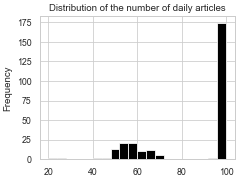

In [12]:
daily_articels.plot.hist(color = 'k', bins = 20, legend = False, title = 'Distribution of the number of daily articles')

Text(0.5, 0, 'Number of articles ')

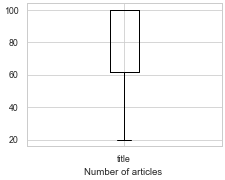

In [13]:
ax = daily_articels.boxplot(color = 'k')
ax.set_xlabel('Number of articles ')

Most days have between 65 and a 100 articles with the lowest number of articles being 20

We now inspect the distribution of the external dataset as reference

In [14]:
news_dataset = pd.read_csv('D:/Downloads/archive/news.csv') #Retrieve the original dataset
news_dataset['date'] = pd.to_datetime(news_dataset.timestamp).dt.date #Change type to datetime

<AxesSubplot:>

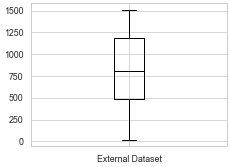

In [15]:
news_dataset_daily = news_dataset\
            .groupby(by = 'date', as_index=False)\
            .count()[['title', 'date']] \
            .rename(columns= {"title": 'External Dataset'})#Count the number of articles per day
news_dataset_daily.boxplot(color = 'k') #Show distribution of the number of daily articles


<AxesSubplot:title={'center':'Distribution of daily articles'}, ylabel='Frequency'>

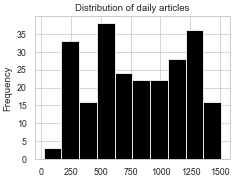

In [16]:
news_dataset_daily.plot.hist(color = 'k', legend = False, title= 'Distribution of daily articles') #Create histogram of the number of articles per day


Articles collected by scraper

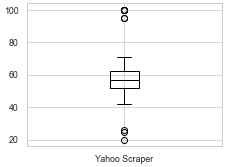

In [17]:
da = daily_articels.reset_index().sort_values(by= 'date').rename(columns = {'title': 'Yahoo Scraper'})
da["date"] = pd.to_datetime(da['date']).dt.date
da = da[da['date'] > date(2020,11,22) ]
da.boxplot(color = 'k')
plt.savefig('D:/Documents/School/Thesis/Figures/FundBoxplotDailyArticlesInternalDataSet')

In [18]:
news_dataset_daily.describe() #Show descriptive statistics for the number of daily articles

,External Dataset
count,238.000000
mean,812.092437
std,387.710384
min,20.000000
25%,486.000000
50%,806.500000
75%,1190.000000
max,1508.000000


We notice in the external dataset we have a lot more articles per day.
Yet the collection of articles fluctuated greatly on a daily basis ranging from 1508 to a minimum of 20
Nevertheless on average we obtained a very rich dataset with more than 800 articles on average

#### Topics of the articles
Some articles start with the topic it concerns, there are 5 major topic labels used:
Business, News, Politics, Health and World
We calculated these features after cleaning the text, all information on how it was done can be found
in [preprocessing.py](preprocessing.py)


News        986
Business    474
Health      316
World       259
Politics     25
dtype: int64


Text(0, 0.5, 'Topic')

<Figure size 1440x1440 with 0 Axes>

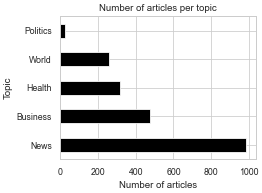

In [19]:
distr_topics = yf_news_df[['Business', 'News', 'Politics', 'Health', 'World']].\
                sum().\
                sort_values(ascending=False) # Calculate the distribution of each topic
print(distr_topics) # Show numeric values of distribution
plt.figure(figsize=(20,20))
pd.DataFrame(distr_topics).plot(kind = 'barh',
                                legend = False,
                                color = 'k',
                                title= 'Number of articles per topic') # Show graphically
plt.xlabel('Number of articles')
plt.ylabel('Topic')


The majority is labeled the generic title of *News*
Second most is *Business*
Only 7 articles contains the label *Politics*

#### Source of the article
Often Articles contain the source of the article in the start of the article between brackets for example
*(Reuters)*
We created a label for all the major sources and display the distribution of them below

RT      13405
BL       3470
YF        849
CNBC      741
dtype: int64


<Figure size 1440x1440 with 0 Axes>

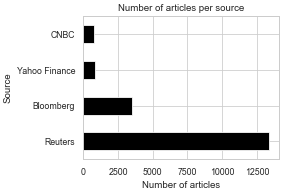

In [36]:
sources_distr = yf_news_df[['BL', 'RT', 'YF', 'CNBC']].sum().\
                                                    sort_values(ascending=False) # Calculate the occurances for each source
print(sources_distr) #Show numeric distribution of the news sources

plt.figure(figsize=(20,20))
pd.DataFrame(sources_distr).rename(index= {'BL': 'Bloomberg', 'RT': 'Reuters', 'YF': 'Yahoo Finance'})\
                .plot(kind = 'barh',
                 legend = False,
                 color = 'k',
                 title = 'Number of articles per source')
plt.xlabel('Number of articles')
plt.ylabel('Source')
plt.savefig('D:Downloads/articlesPerSource')


Most articles are from Reuters, followed by Bloomberg

#### Distribution of the sentiment
Subjectivity [0,1]: 0 = Very Objective -> 1 = Very subjective
Polarity [-1,1]: -1 = Very Negative -> 1 = Very Positive

,subjectivity,polarity
count,22468.000000,22468.000000
mean,0.209294,0.028702
std,0.276947,0.199111
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.400000,0.033333
max,1.000000,1.000000


<AxesSubplot:>

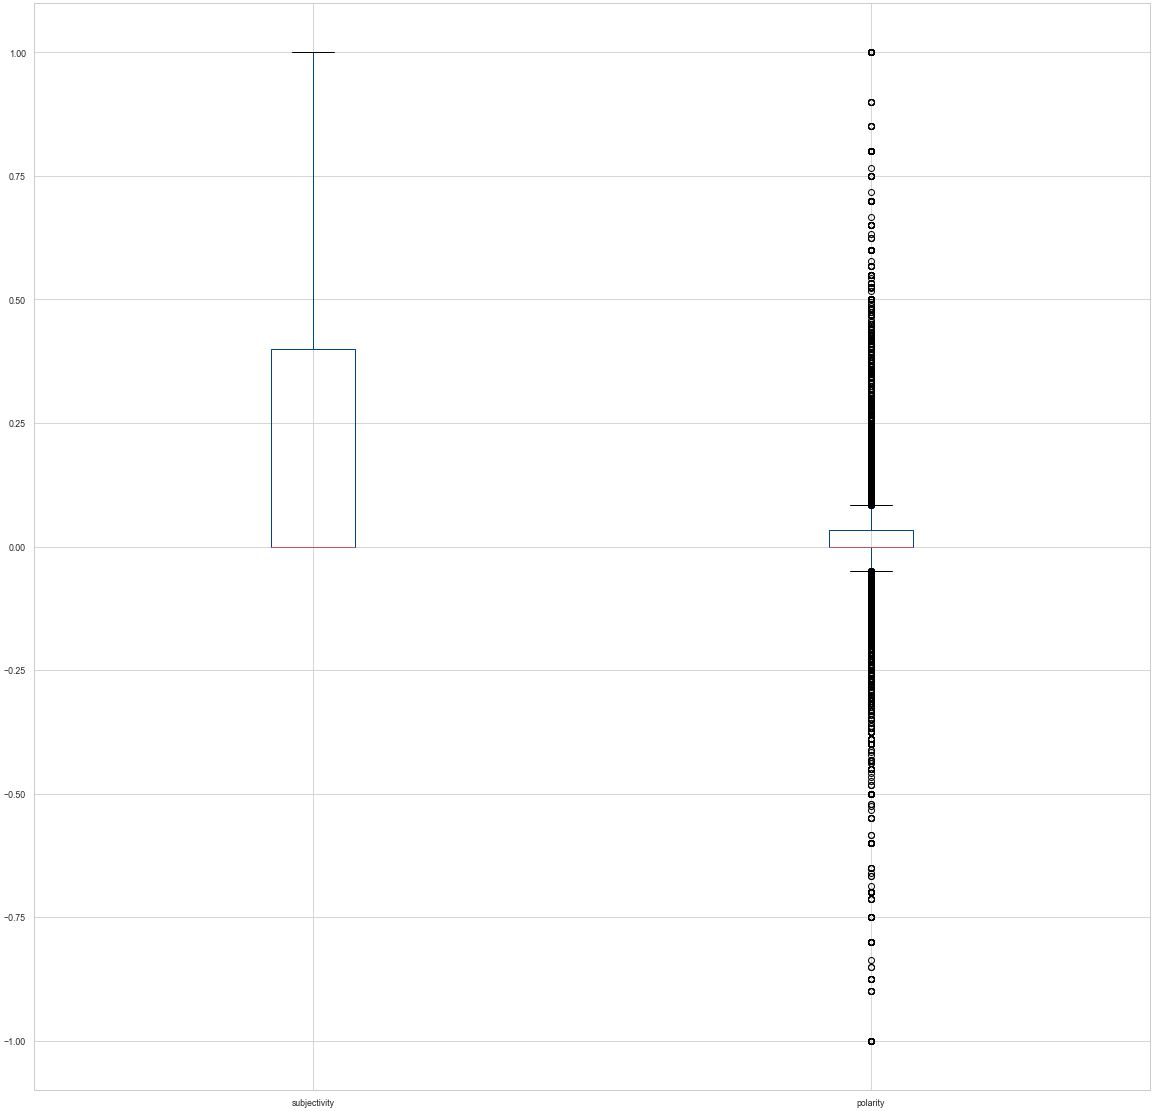

In [21]:
display(yf_news_df[['subjectivity', 'polarity']].describe()) #Show summary of subj and polarity
plt.figure(figsize=(20,20))
yf_news_df[['subjectivity', 'polarity']].boxplot() # Show visual of distr

Average subjectivity around  0.2 which is closer to objective
Average polarity around 0.02 which is almost neutral
The boxplot of polarity (right) shows us almost all values are close to zero since
any observations deviating from zero is indicated as an *"outlier"*

In [22]:
# Calculate general statistics of the number of articles labeled 0 for polarity and subjectivity
print('Number of articles with a subjectivity labeled 0: ', len(yf_news_df[yf_news_df['subjectivity'] == 0]))
print('Number of articles with a polarity labeled 0: ', len(yf_news_df[yf_news_df['polarity'] == 0]))
print('Proportion of articles with a subjectivity labeled 0: ', len(yf_news_df[yf_news_df['subjectivity'] == 0])/ len(yf_news_df))
print('Proportion of articles with a polarity labeled 0: ', len(yf_news_df[yf_news_df['polarity'] == 0])/ len(yf_news_df))

Number of articles with a subjectivity labeled 0:  11830
Number of articles with a polarity labeled 0:  13213
Proportion of articles with a subjectivity labeled 0:  0.5265266156311198
Proportion of articles with a polarity labeled 0:  0.5880808260637351


For both more than half of the observation is labeled with zero
Since we did not impute missing values yet, this is not due to imputation but due to
the way these values are calculated by the textblob package

#### Evolution of sentiment and polarity over time

In [23]:
def mean_sentiment_month(df): #Function that calculates the values for each month
    df['date'] = pd.to_datetime(df['date']) #Change type to datetime
    mean = df.groupby([df.date.dt.year, df.date.dt.month]).mean() #Group by year and month and calculate mean
    return mean

<ipython-input-23-4f13919626b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']) #Change type to datetime


<AxesSubplot:xlabel='date,date'>

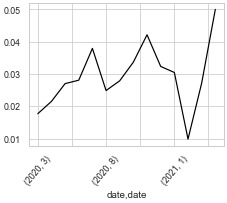

In [24]:
mean = mean_sentiment_month(yf_news_df[['date', 'polarity']]) #Calculate evolution of polarity
mean.plot(rot = 50, legend = False, color = 'k') #Visualise evolution

<ipython-input-23-4f13919626b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']) #Change type to datetime


<AxesSubplot:xlabel='date,date'>

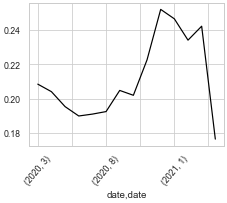

In [25]:
mean = mean_sentiment_month(yf_news_df[['date', 'subjectivity']]) #Calculate evolution of subjectivity
mean.plot(rot = 50, legend = False, color = 'k') #Visualise evolution

#### Mentions of specific stock in articles
We check this by searching for the use of the name in the articles

AAPL    123
AMZN    105
FB      104
GOOG     69
NFLX     24
dtype: int64


Text(0, 0.5, 'Company')

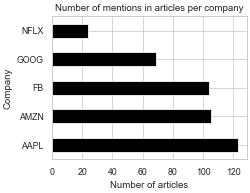

In [26]:
stock_mentions = yf_news_df[get_names()].\
                sum().\
                sort_values(ascending=False) # Calculate the mentions of each stock in the news articles collected
print(stock_mentions) # Show numeric values of distribution
pd.DataFrame(stock_mentions).plot(kind = 'barh', legend = False, color = 'k', title = 'Number of mentions in articles per company') # Show graphically
plt.xlabel('Number of articles')
plt.ylabel('Company')

We notice in general we do not have a lot of articles where the name of a stock is mentioned

#### Human Sentiment
We check if in the articles sugesstions are given in terms of to either buy or sell stock
In literature this is labeled as *__Human Sentiment__*
We check if in the text word such as buy, sell or hold are mentioned.
This method is mainly popular in financial forecasting using social media, nevertheless we
check if such labels are available in news articles


hold    616
buy     391
sell    355
dtype: int64


Text(0, 0.5, 'Human Sentiment')

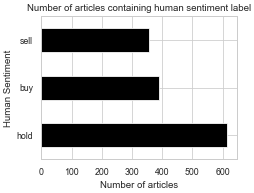

In [27]:
yf_news_df['hold'] = np.where(yf_news_df.title.str.contains('hold') | yf_news_df.text.str.contains('hold'), 1, 0)
yf_news_df['buy'] = np.where(yf_news_df.title.str.contains('buy') | yf_news_df.text.str.contains('buy'), 1, 0)
yf_news_df['sell'] = np.where(yf_news_df.title.str.contains('sell') | yf_news_df.text.str.contains('sell'), 1, 0)

human_sentiment = yf_news_df[['buy','hold', 'sell']].\
                sum().\
                sort_values(ascending=False) # Calculate the mentions of each stock in the news articles collected
print(human_sentiment) # Show numeric values of distribution
pd.DataFrame(human_sentiment).plot(kind = 'barh', legend = False, color = 'k', title= 'Number of articles containing human sentiment label') # Show graphically
plt.xlabel('Number of articles')
plt.ylabel('Human Sentiment')


We find more articles containing the advice to buy, sell or hold than we found mentions if specific companies


#### Aggregate news articles for each day
In our feature set we will make use of the aggregated features mentioned above for each day
Therefore we will now group all articles per day

In [28]:
# Change from timestamp to only date
yf_news_df['date'] = pd.to_datetime(yf_news_df.date)
yf_news_df['date'] = yf_news_df['date'].dt.date
# Aggregate to values per day
news_gr = yf_news_df.groupby(by='date', as_index=False).agg(
        {'BL': 'sum', 'RT': 'sum', 'YF': 'sum', 'CNBC': 'sum', 'Business': 'sum', 'News': 'sum', 'Politics': 'sum',
         'Health': 'sum', 'World': 'sum', 'polarity': 'mean', 'subjectivity': 'mean', 'AAPL': 'sum', 'FB': 'sum', 'GOOG': 'sum',
         'AMZN': 'sum', 'NFLX': 'sum', 'hold': 'sum', 'buy': 'sum', 'sell': 'sum'})

,BL,RT,YF,CNBC,Business,News,Politics,Health,World,polarity,subjectivity,AAPL,FB,GOOG,AMZN,NFLX,hold,buy,sell
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,13.193916,50.969582,3.228137,2.817490,1.802281,3.749049,0.095057,1.201521,0.984791,0.028385,0.214323,0.467681,0.395437,0.262357,0.399240,0.091255,2.342205,1.486692,1.349810
std,11.007477,32.850794,5.084144,6.460461,1.803007,4.862003,0.330530,1.425396,1.178593,0.028406,0.043471,0.845905,0.728049,0.527479,0.733807,0.379885,1.566834,1.427248,1.451266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.068254,0.101803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010139,0.185846,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,15.000000,64.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.030088,0.207796,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
75%,21.000000,80.000000,6.000000,0.000000,3.000000,6.000000,0.000000,2.000000,2.000000,0.047010,0.235438,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,2.000000
max,43.000000,91.000000,26.000000,28.000000,9.000000,22.000000,3.000000,10.000000,6.000000,0.093125,0.349312,4.000000,4.000000,2.000000,4.000000,4.000000,8.000000,7.000000,8.000000


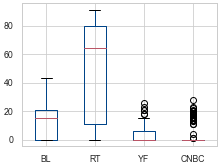

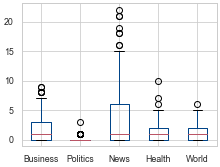

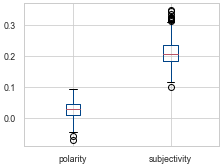

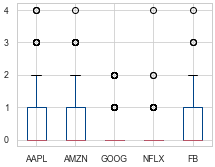

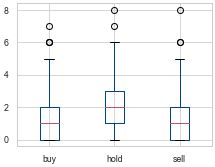

In [29]:
display(news_gr.describe())

news_gr[['BL', 'RT', 'YF', 'CNBC']].boxplot()
plt.show()

news_gr[['Business', 'Politics', 'News', 'Health', 'World']].boxplot()
plt.show()

news_gr[['polarity', 'subjectivity']].boxplot()
plt.show()

news_gr[['AAPL', 'AMZN', 'GOOG', 'NFLX', 'FB']].boxplot()
plt.show()

news_gr[['buy', 'hold', 'sell']].boxplot()
plt.show()

- Sources: We seem to have a good variance and amount of values for Bloomberg and Reuters but little variance for CNBC
- Topics: On average we have a value of 1 for each day and some variance in the amount except for Politics
- Polarity and Subjectivity: Due to aggregation these features seem to be a bit more interesting with less outliers for polarity than before
- Stock: Except for AMZN and FB these features are almost always zero, all medians are zero and
- Human Sentiment: All average are above zero and all seem to have IQR 2


### Correlation between calculated features and label
We want our features to have a high correlations with our label since this could suggest a good predictive
power.

In [30]:
def corr_plot(news_gr, tck):
    # Calculate label: Up or down: 1 or 0
    tech_table = get_technical_table()
    tech_table = tech_table[tech_table['ticker']== tck]
    tech_table = tech_table.sort_values(by='date').reset_index(drop = True)
    tech_table['label'] = np.where(tech_table['close'].shift(-1) <= tech_table['close'], 0, 1)
    label = tech_table[['date', 'label']]
    merged = pd.merge(label, news_gr, on = 'date', how= 'left')
    buy_Corr = merged.corr()["label"]
    buy_Corr= buy_Corr[np.argsort(buy_Corr, axis = 0)[::-1]] #sort in descending order
    buy_Corr = buy_Corr[1:26] # remove the 'Survived'

    # Plot the top correlationin a bar chart for east visualisation.
    width = 0
    fig, ax = plt.subplots(figsize = (10,6))
    rects = ax.barh(np.arange(len(buy_Corr)), np.array(buy_Corr.values), color = 'k')
    ax.set_yticks(np.arange(len(buy_Corr)) + ((width)/1))
    ax.set_yticklabels(buy_Corr.index, rotation ='horizontal')
    ax.set_xlabel("Correlation coefficient")
    ax.set_title("{} - Correlation Coefficients w.r.t buy/sell".format(tck),fontsize = 14);
    ax.grid(True)

#### APPLE

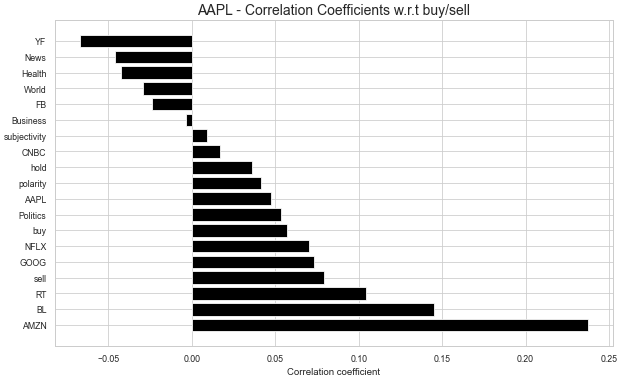

In [31]:
tck = 'AAPL'
corr_plot(news_gr, tck)

#### AMZN

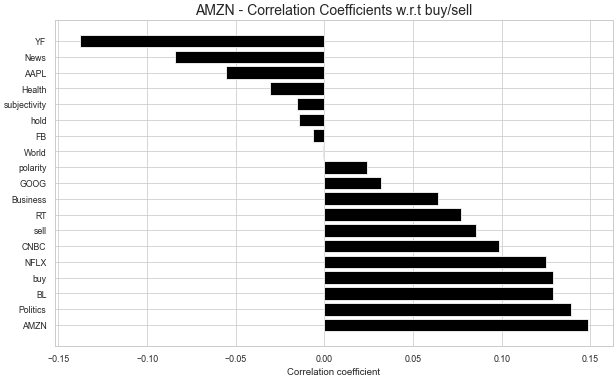

In [32]:
tck = 'AMZN'
corr_plot(news_gr, tck)

#### GOOG

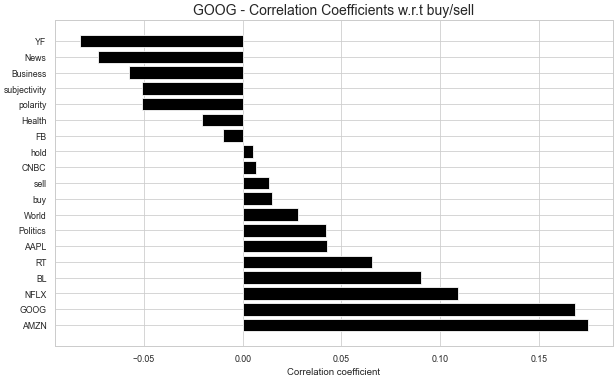

In [33]:
tck = 'GOOG'
corr_plot(news_gr, tck)


#### FB

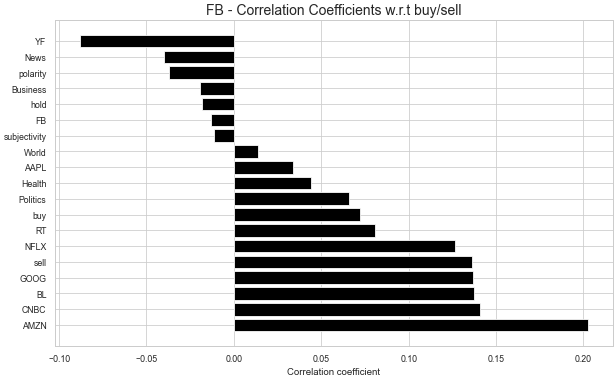

In [34]:
tck = 'FB'
corr_plot(news_gr, tck)


#### NFLX

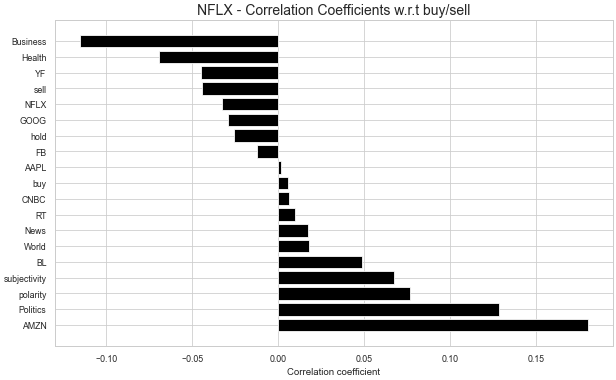

In [35]:
tck = 'NFLX'
corr_plot(news_gr, tck)